In [1]:
import xarray as xr
%matplotlib widget
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import pandas as pd
import numpy as np

In [2]:
def time_integrate(da):
    dt = (da.time[1].values - da.time[0].values).astype('timedelta64[s]').astype('int')
    weights = xr.ones_like(da.time, dtype="float")/3.0
    weights[1:-1:2] *= 4
    weights[2:-2:2] *= 2
    if weights.size % 2 == 0:
        weights[-2] = 1/3 + 0.5
        weights[-1] = 0.5
    return (da*weights*dt).sum("time")

def shift_longitudes(ds):
    ds_shift = ds.assign_coords(lon=ds.lon.where(ds.lon<180,ds.lon-360))
    return ds_shift.roll(lon=ds_shift.lon.size//2, roll_coords=True)

def rename_coords(da):
    return da.rename({c:c[:3] for c in da.dims if c!="time"})

In [3]:
dsJ1=xr.open_dataset("e5.oper.an.pl.128_lvint.ll025sc.2019060100_2019073118.nc")
dsJ1

<xarray.Dataset> Size: 7GB
Dimensions:     (lon: 1439, lat: 240, time: 244)
Coordinates:
  * lon         (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6
  * lat         (lat) float64 2kB 15.12 15.38 15.62 15.88 ... 74.38 74.62 74.88
  * time        (time) datetime64[ns] 2kB 2019-06-01 ... 2019-07-31T18:00:00
Data variables: (12/20)
    AeLp        (time, lat, lon) float32 337MB ...
    qedV_AeLp   (time, lat, lon) float32 337MB ...
    ACON_AeLp   (time, lat, lon) float32 337MB ...
    qevp        (time, lat, lon) float32 337MB ...
    etap        (time, lat, lon) float32 337MB ...
    AeLm        (time, lat, lon) float32 337MB ...
    ...          ...
    DUeAeLp     (time, lat, lon) float64 674MB ...
    DUeAeLm     (time, lat, lon) float64 674MB ...
    Qe          (time, lat) float32 234kB ...
    dQedY       (time, lat) float32 234kB ...
    Ae          (time, lat) float32 234kB ...
    qedV_Ae     (time, lat) float32 234kB ...
Attributes: (12/15)
    long_name:                     Temperature
    short_name:                    t
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               130
    ...                            ...
    rda_dataset:                   ds633.0
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi:               DOI: 10.5065/BH6N-5N20
    rda_dataset_group:             ERA5 atmospheric pressure level analysis [...
    number_of_significant_digits:  7
    history:                       September 13 2024 0233Z - wave activity bu...

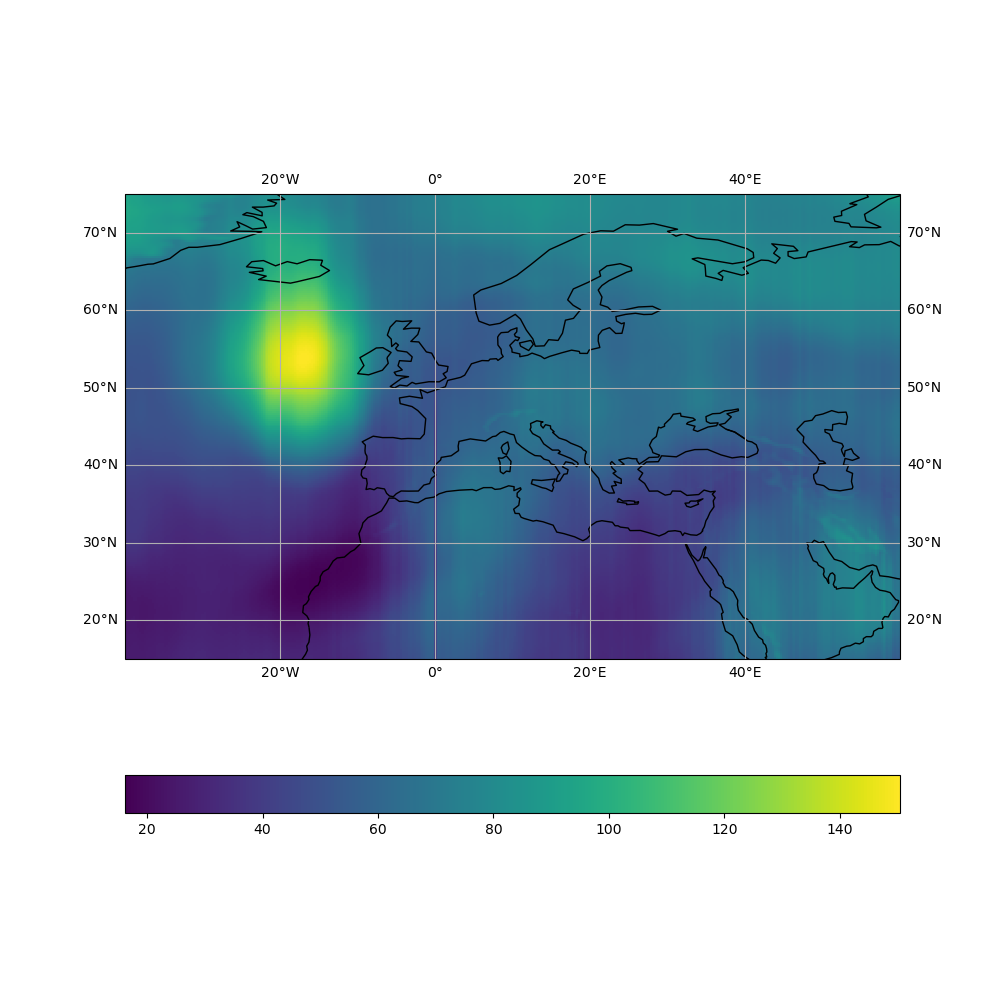

In [4]:
plt.close("all")
ds_shift = shift_longitudes(dsJ1.sel(time=slice("2019-06-22T12:00:00", "2019-06-29T00:00:00")))
ds_peak = ds_shift.sel(lon=slice(-40,60))
lwa=ds_peak.AeLp - ds_peak.AeLm
lwa=lwa.mean(dim="time")
plt.figure(figsize=(10,10))
ax=plt.axes(projection=ccrs.PlateCarree())
lwa.plot(x="lon", y="lat", cbar_kwargs={"location":"bottom"})
ax.coastlines()
ax.gridlines(draw_labels=True)

In [5]:
peak_lwa = lwa.max()
peak_coords = lwa.where(lwa == peak_lwa, drop=True).squeeze()
peak_lon = peak_coords.lon.values
peak_lat = peak_coords.lat.values

print(f"Peak LWA at lon: {peak_lon}, lat: {peak_lat}")

Peak LWA at lon: -16.625, lat: 53.625


In [6]:
win_width = 15
lon_min, lon_max = peak_lon - win_width/2, peak_lon + win_width/2
lat_min, lat_max = peak_lat - win_width/2, peak_lat + win_width/2
region_dict = {"lon": slice(lon_min, lon_max), "lat": slice(lat_min, lat_max)}
region = lwa.sel(region_dict)
print(lon_min, lon_max, lat_min, lat_max)

-24.125 -9.125 46.125 61.125


In [7]:
dsJ2=xr.open_dataset("e5.oper.an.pl.128_ep_geo_flx.ll025sc.2019060100_2019073118.nc")
dsJ2


<xarray.Dataset> Size: 3GB
Dimensions:       (lon: 1439, lat: 240, time: 244)
Coordinates:
  * lon           (lon) float64 12kB 0.125 0.375 0.625 ... 359.1 359.4 359.6
  * lat           (lat) float32 960B 15.12 15.38 15.62 ... 74.38 74.62 74.88
  * time          (time) datetime64[ns] 2kB 2019-06-01 ... 2019-07-31T18:00:00
Data variables:
    EMFC          (time, lat, lon) float32 337MB ...
    EHFC          (time, lat, lon) float32 337MB ...
    E             (time, lat, lon) float32 337MB ...
    GEO_EMF_BETA  (time, lat, lon) float64 674MB ...
    AGEO_EVF      (time, lat, lon) float64 674MB ...
    EEFC          (time, lat, lon) float32 337MB ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r1i7n13 4.12.14-94.41-default #1 SMP Wed Oct ...
    CONVERSION_DATE:      Wed Oct  2 13:30:29 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Wed Oct  2 13:30:47 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

In [8]:
U = xr.open_dataset("e5.oper.an.pl.128_131_u.ll025uv.2019060100_2019073118.nc")["U"]

In [9]:
# A 
time_range = slice("2019-06-21T00:00:00", "2019-07-02T00:00:00")
ds_shiftJ1 = shift_longitudes(dsJ1.sel(time=time_range))
# Select the block region
block_regionJ1 = ds_shiftJ1.sel(region_dict)
Ael= block_regionJ1.AeLp - block_regionJ1.AeLm
Aavg= Ael.mean(dim=['lat', 'lon'])
peak_time = Aavg.where(Aavg==Aavg.max(),drop=True).time.values.squeeze()

In [10]:
#F 
#F = F1 - F2 + F3 
# F = UeAeL - (ACON_AeL - UeAeL) + E 

ds_shiftJ2 = shift_longitudes(dsJ2.sel(time=time_range))
#Select block region 
block_regionJ2 = ds_shiftJ2.sel(region_dict)
UeAeL= block_regionJ1.UeAeLp - block_regionJ1.UeAeLm
ACON_AeL= block_regionJ1.ACON_AeLp - block_regionJ1.ACON_AeLm
F = (ACON_AeL) + block_regionJ2.E
Favg = F.mean(dim=['lat', 'lon'])

In [11]:
Uregion = shift_longitudes(U.sel(time=time_range)).sel(region_dict)
Uavg = Uregion.mean(["lat","lon"])
print(Uavg[:8].mean())

<xarray.DataArray 'U' ()> Size: 4B
array(6.7621036, dtype=float32)


In [12]:
dstemp=rename_coords(xr.open_dataset("e5.oper.an.sfc.128_167_2t_nh.ll025sc.2019060100_2019073118.nc")).rename(VAR_2T="T")
lsm = rename_coords(xr.open_dataset("e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.squeeze(drop=True))
dstemp

<xarray.Dataset> Size: 507MB
Dimensions:   (time: 244, lat: 361, lon: 1440)
Coordinates:
  * lat       (lat) float64 3kB 90.0 89.75 89.5 89.25 89.0 ... 0.75 0.5 0.25 0.0
  * lon       (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time      (time) datetime64[ns] 2kB 2019-06-01 ... 2019-07-31T18:00:00
Data variables:
    T         (time, lat, lon) float32 507MB ...
    utc_date  (time) int32 976B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r10i6n6 4.12.14-94.41-default #1 SMP Wed Oct ...
    CONVERSION_DATE:      Wed Oct  2 14:47:20 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Sep 30 16:56:13 2024: ncks -d latitude,0.0,90.0...
    NCO:                  netCDF Operators version 5.2.7 (Homepage = http://n...

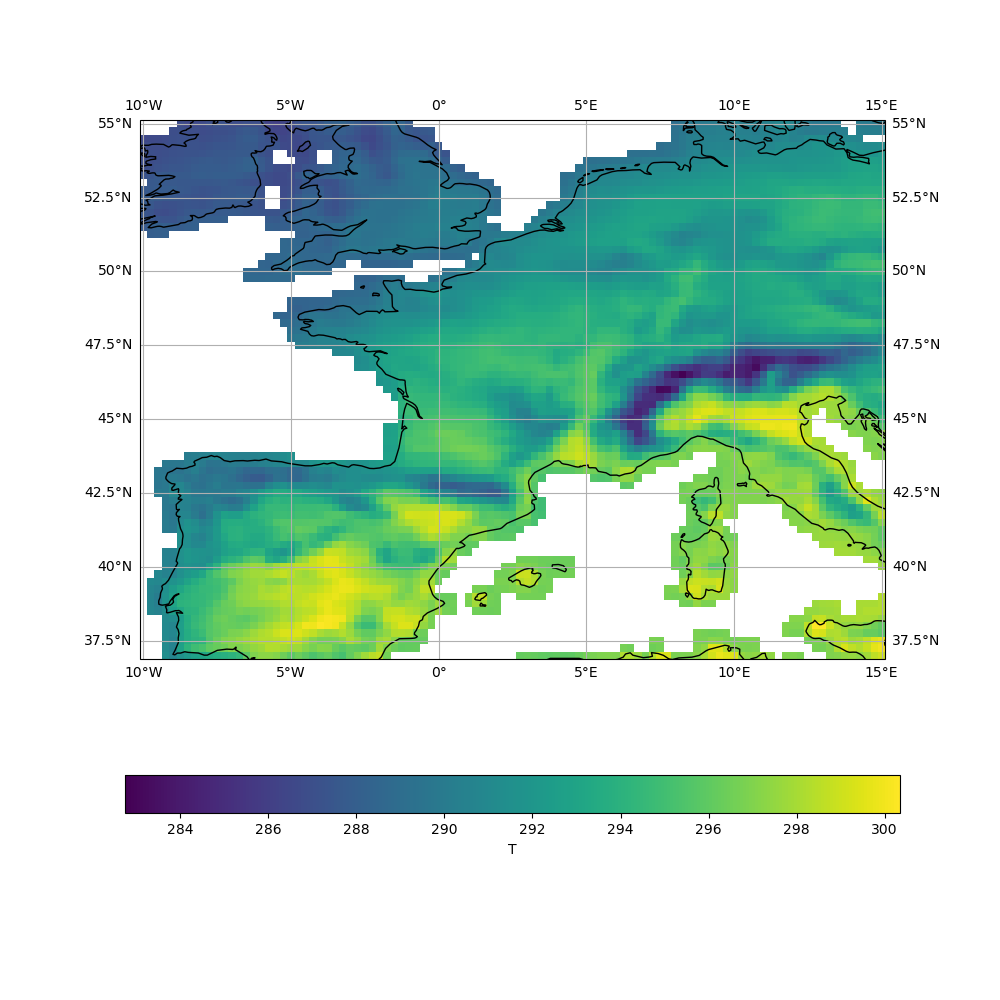

In [13]:
#Plot of temperature
plt.close("all")

t_region = {"lon":slice(-10,15), "lat":slice(55,37)}
ds_shiftT = shift_longitudes(dstemp.T)
ds_peakT = ds_shiftT.sel(t_region)
shift_lsm = shift_longitudes(lsm).sel(t_region)
plt.figure(figsize=(10,10))
ax=plt.axes(projection=ccrs.PlateCarree())
T=ds_peakT.mean(dim="time").where(shift_lsm)
T.plot(x="lon", y="lat", cbar_kwargs={"location":"bottom"})
ax.coastlines()
ax.gridlines(draw_labels=True)

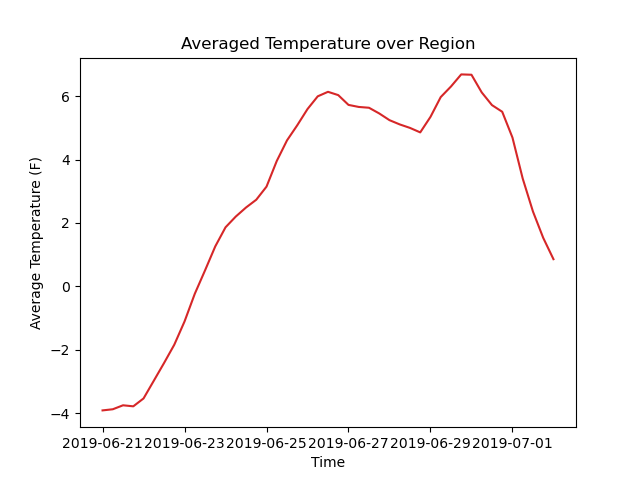

In [15]:
#Region averaged T 
RegionT = ds_shiftT.sel(t_region)
Tavg = RegionT.where(shift_lsm).mean(dim=['lat', 'lon'], skipna=True)
Tmean = Tavg.mean('time')
Tavg_smoothed = (Tavg.rolling(time=4, center=True).mean().sel(time=time_range)-Tmean) * 9/5
fig, ax = plt.subplots()

# Plot the averaged temperature
ax.plot(Tavg_smoothed['time'], Tavg_smoothed, color='tab:red')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Average Temperature (F)')
ax.set_title('Averaged Temperature over Region')

# Show the plot
plt.show()

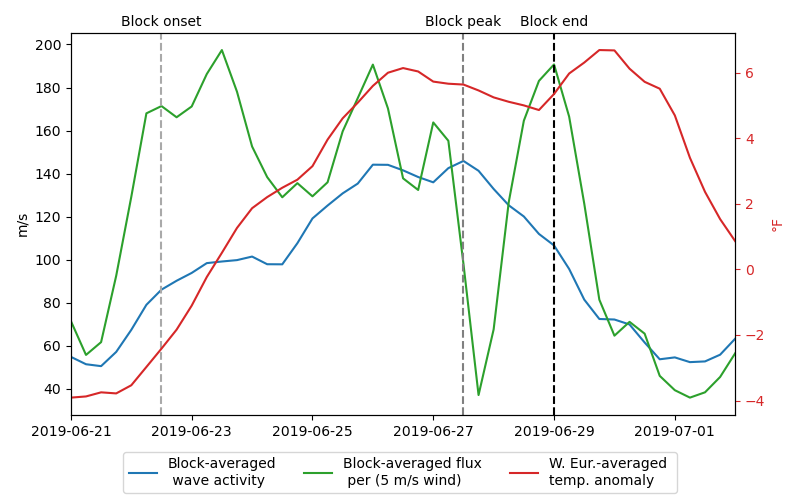

In [16]:
#Plots
plt.close("all")
plt.figure(figsize=(8, 5))
ax = plt.gca()
h1, = ax.plot(Aavg.time, Aavg, label="Block-averaged\n wave activity", color="tab:blue")
ax.set_ylabel('m/s')
h2, = ax.plot(Favg.time, (Favg/5), label="Block-averaged flux\n per (5 m/s wind)", color="tab:green")
h3 = plt.axvline(pd.to_datetime("2019-06-22T12"), color='darkgray', linestyle='--', label="Block onset")
ax.text(pd.to_datetime("2019-06-22T12"), 207, "Block onset", ha="center", va="bottom")
h4 = plt.axvline(peak_time, color='gray', linestyle='--', label="Block peak")
ax.text(peak_time, 207, "Block peak", ha="center", va="bottom")
h5 = plt.axvline(pd.to_datetime("2019-06-29"), color='black', linestyle='--', label="Block end")
ax.text(pd.to_datetime("2019-06-29"), 207, "Block end", ha="center", va="bottom")
# ax.axhline(0,lw=.75,c='k')
plt.xlim(Aavg.time[0], Aavg.time[-1])
# ax.tick_params("x",rotation=30)
# plt.title("Block-averaged A and F over Time during the block\n alongside with average temperature over the region")
plt.tight_layout()

# Temperature axis 
ax2 = ax.twinx()
h6, = ax2.plot(Tavg_smoothed.time, Tavg_smoothed, label="W. Eur.-averaged \ntemp. anomaly", color="tab:red", linestyle='-')


ax2.set_ylabel('\u00b0F', c="tab:red")
ax2.tick_params(axis='y', color="tab:red", labelcolor="tab:red")


# plt.legend(handles=[h1, h2, h6, h3, h4, h5], loc="lower left", ncols=2)
# plt.gcf().legend(handles=[h1, h2, h6, h3, h4, h5], loc="lower center", ncols=3)
plt.gcf().legend(handles=[h1, h2, h6], loc="lower center", ncols=3)
plt.tight_layout()
plt.subplots_adjust(bottom=0.17)
# plt.subplots_adjust(bottom=0.25)

plt.show()
#Average temperature around peak temp region then plot alongside
#Find peak temperature


Text(0.5, 1.0, 'Scatter plot of F vs A with colorpoints')

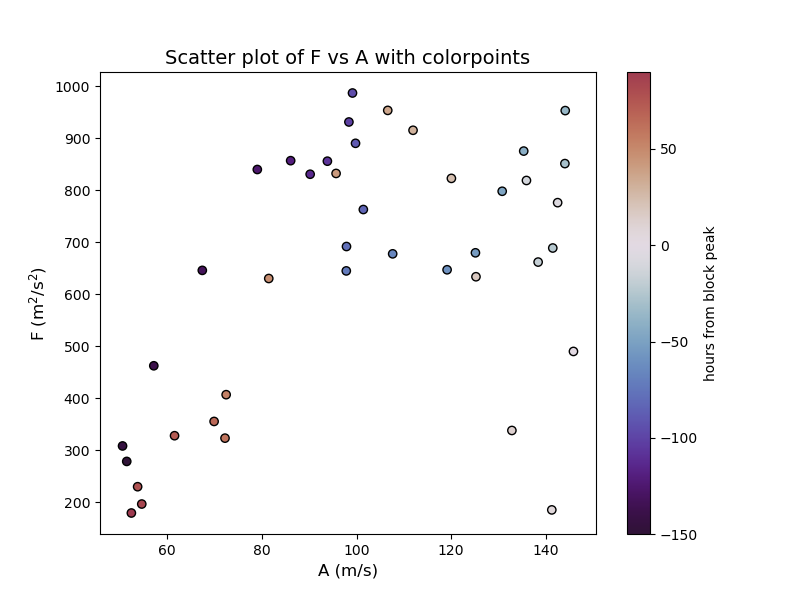

In [21]:
#Plot of F and A

plt.close("all")
num_timesteps = len(Favg.time)
rel_times = (Aavg.time.values.astype('datetime64[h]') - peak_time.astype('datetime64[h]')).astype('int')
F1avg = UeAeL.mean(["lat","lon"])
F2avg = (ACON_AeL-UeAeL).mean(["lat","lon"])
F3avg = (block_regionJ2.E).mean(["lat","lon"])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(Aavg, Favg, c=rel_times, cmap="twilight_shifted", vmin=rel_times[0], vmax=-rel_times[0], edgecolor='k')
# scatter = plt.scatter(Aavg, F2avg, c=rel_times, cmap="twilight_shifted", vmin=rel_times[0], vmax=-rel_times[0], edgecolor='k')

plt.xlabel("A (m/s)", fontsize=12)
plt.ylabel("F (m$^{2}$/s$^{2}$)", fontsize=12)

cbar = plt.colorbar(scatter, label="hours from block peak")
cbar.ax.set_ylim(rel_times[0], rel_times[-1])

plt.title("Scatter plot of F vs A with colorpoints", fontsize=14)

Text(0.5, 1.0, 'Cumulative sum of I, II and III in NH18')

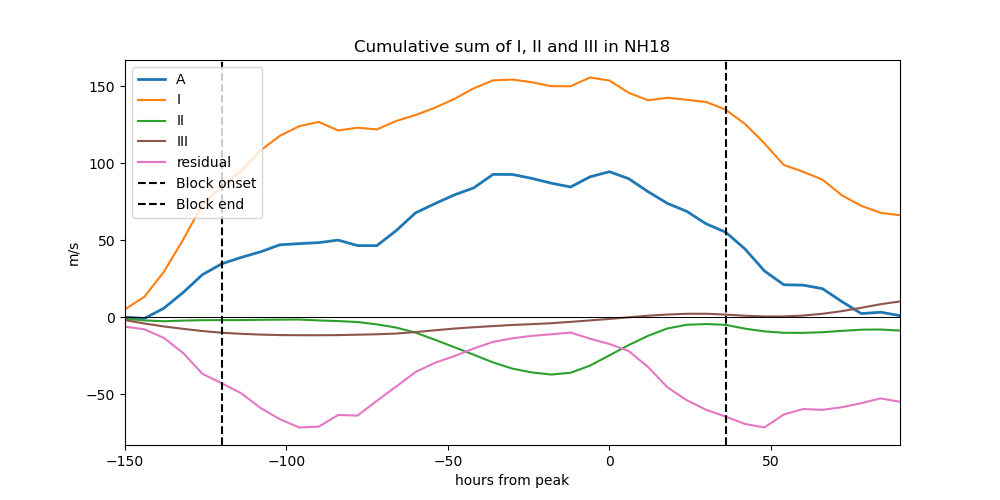

In [15]:
# Same task for cumulative sum of I, II, and III
plt.close("all")

I= block_regionJ2.EEFC + block_regionJ1.DACON_AeLp - block_regionJ1.DACON_AeLm
II = block_regionJ2.EMFC
III = block_regionJ2.EHFC
resid = Aavg.differentiate('time', edge_order=2, datetime_unit='s')+block_regionJ1.qevp-block_regionJ1.qevm+block_regionJ1.DACON_AeLp - block_regionJ1.DACON_AeLm

CumulsumI = (-I*6*3600).mean(dim=['lat', 'lon']).cumsum('time')
CumulsumII = (-II*6*3600).mean(dim=['lat', 'lon']).cumsum('time')
CumulsumIII = (-III*6*3600).mean(dim=['lat', 'lon']).cumsum('time')
Cumulsumavg = CumulsumI+CumulsumII+CumulsumIII
Cumulresid = (resid*6*3600).mean(dim=['lat', 'lon']).cumsum('time')

#Plot
plt.figure(figsize=(10, 5))
# plt.plot(rel_times, Cumulsumavg, label="I, II and III", color="tab:red")
plt.plot(rel_times, Aavg-Aavg[0].squeeze(), label="A", lw=2)
plt.plot(rel_times, CumulsumI, label="I")
plt.plot(rel_times, CumulsumII, label="II")
plt.plot(rel_times, CumulsumIII, label="III",c="tab:brown")
plt.plot(rel_times, Cumulresid, label="residual", c="tab:pink")
plt.axhline(0, lw=0.75, c='k')
plt.axvline((np.datetime64("2019-06-22T12")-peak_time.astype("datetime64[h]")).astype("int"), color='black', linestyle='--', label="Block onset")
plt.axvline((np.datetime64("2019-06-29T00")-peak_time.astype("datetime64[h]")).astype("int"), color='black', linestyle='--', label="Block end")
plt.legend()
plt.xlim(rel_times[0], rel_times[-1])
plt.xlabel("hours from peak")
plt.ylabel("m/s")
plt.title("Cumulative sum of I, II and III in NH18")

Text(0, 0.5, 'm/s')

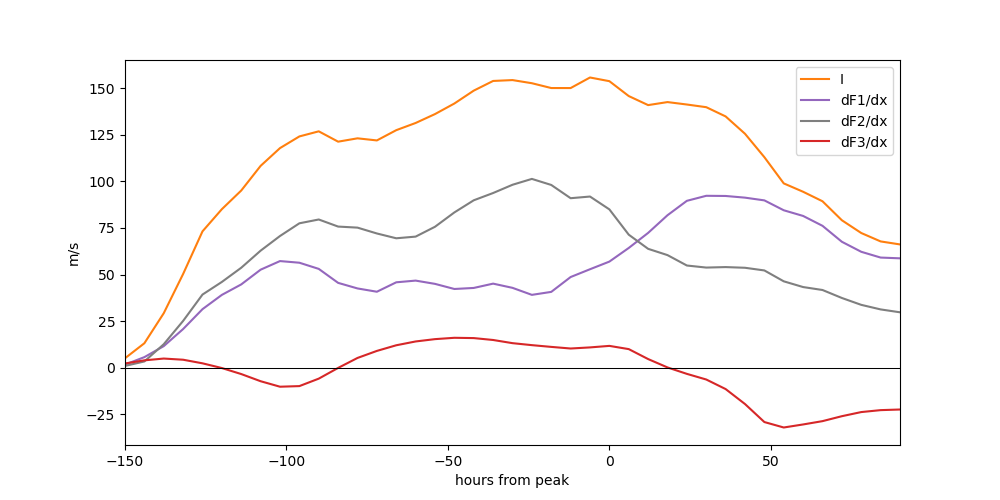

In [16]:
dF1dx = block_regionJ1.DUeAeLp - block_regionJ1.DUeAeLm
dF2dx = block_regionJ1.DACON_AeLp - block_regionJ1.DACON_AeLm - block_regionJ1.DUeAeLp + block_regionJ1.DUeAeLm
CumulF1 = -dF1dx.mean(dim=["lat","lon"]).cumsum('time')*6*3600
CumulF2 = -dF2dx.mean(dim=["lat","lon"]).cumsum('time')*6*3600
CumulF3 = -block_regionJ2.EEFC.mean(dim=["lat","lon"]).cumsum('time')*6*3600

plt.close("all")
plt.figure(figsize=(10,5))
plt.plot(rel_times, CumulsumI, label="I", c="tab:orange")
plt.plot(rel_times, CumulF1, label="dF1/dx", c="tab:purple")
plt.plot(rel_times, CumulF2, label="dF2/dx", c="tab:grey")
plt.plot(rel_times, CumulF3, label="dF3/dx", c="tab:red")
plt.axhline(0, lw=0.75, c='k')
plt.legend()
plt.xlim(rel_times[0], rel_times[-1])
plt.xlabel("hours from peak")
plt.ylabel("m/s")

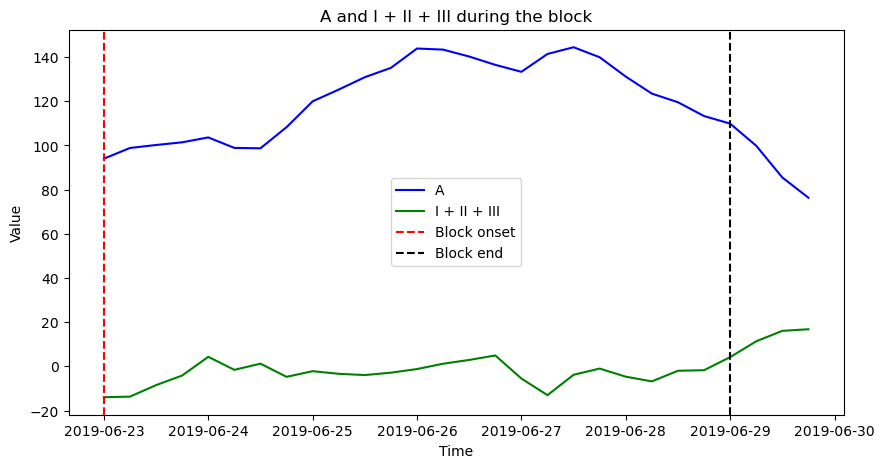

In [32]:
#Comparing sum to A(t) -A(t=0)

Sumeq= Cumulsumavg * 6*3600

plt.figure(figsize=(10, 5))
plt.plot(Aavg.time, Aavg, label="A", color="blue")
plt.plot(Sumeq.time, Sumeq, label="I + II + III", color="green")
plt.axvline(pd.to_datetime("2019-06-23"), color='red', linestyle='--', label="Block onset")
plt.axvline(pd.to_datetime("2019-06-29"), color='black', linestyle='--', label="Block end")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("A and I + II + III during the block")
plt.show()